# 0. Configuration

In [1]:
# links to shared data MovieLens
# source on kaggle: https://www.kaggle.com/code/quangnhatbui/movie-recommender/data
INTERACTIONS_PATH = '/Users/nikitasenyatkin/Documents/Мага/1 курс/Okko/Okko-project-HSE-/Full project pipeline/interactions_df.csv'
ITEMS_METADATA_PATH = 'https://drive.google.com/file/d/12a80lS3vXQOl6i6ENgz-WqWw3Wms0nqB/view?usp=share_link'
USERS_DATA_PATH = 'https://drive.google.com/file/d/1MwPaye0cRi53czLqCnH0bOuvIhOeNlAx/view?usp=share_link'

# 1. Modules and functions

In [2]:
# just to make it available to download w/o SSL verification
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

import shap
import numpy as np
import pandas as pd
import datetime as dt

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from lightfm.data import Dataset
from lightfm import LightFM

from catboost import CatBoostClassifier

from tqdm import tqdm_notebook
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.float_format', lambda x: '%.3f' % x)

LightFM was compiled without OpenMP support. Only a single thread will be used.


## 1. 1. Helper functions to avoid copy paste

In [3]:
def read_csv_from_gdrive(url):
    """
    gets csv data from a given url (taken from file -> share -> copy link)
    :url: example https://drive.google.com/file/d/1BlZfCLLs5A13tbNSJZ1GPkHLWQOnPlE4/view?usp=share_link
    """
    file_id = url.split('/')[-2]
    file_path = 'https://drive.google.com/uc?export=download&id=' + file_id
    data = pd.read_csv(file_path)

    return data

# 2. Main

## 2.1. Load Data

`interactions` dataset shows list of movies that users watched, along with given `total_dur` in seconds and `watched_pct` proportion:

In [4]:
# interactions data
interactions = pd.read_csv(INTERACTIONS_PATH)
interactions.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,2021-05-11,4250,72.000
1,699317,1659,2021-05-29,8317,100.000
2,656683,7107,2021-05-09,10,0.000
3,864613,7638,2021-07-05,14483,100.000
4,964868,9506,2021-04-30,6725,100.000


`movies_metadata` dataset shows the list of movies existing on OKKO platform:

In [5]:
# information about films etc
movies_metadata = read_csv_from_gdrive(ITEMS_METADATA_PATH)
movies_metadata.head(3)

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords
0,10711,film,Поговори с ней,Hable con ella,2002.000,"драмы, зарубежные, детективы, мелодрамы",Испания,NaN,16.000,NaN,Педро Альмодовар,"Адольфо Фернандес, Ана Фернандес, Дарио Гранди...",Мелодрама легендарного Педро Альмодовара «Пого...,"Поговори, ней, 2002, Испания, друзья, любовь, ..."
1,2508,film,Голые перцы,Search Party,2014.000,"зарубежные, приключения, комедии",США,NaN,16.000,NaN,Скот Армстронг,"Адам Палли, Брайан Хаски, Дж.Б. Смув, Джейсон ...",Уморительная современная комедия на популярную...,"Голые, перцы, 2014, США, друзья, свадьбы, прео..."
2,10716,film,Тактическая сила,Tactical Force,2011.000,"криминал, зарубежные, триллеры, боевики, комедии",Канада,NaN,16.000,NaN,Адам П. Калтраро,"Адриан Холмс, Даррен Шалави, Джерри Вассерман,...",Профессиональный рестлер Стив Остин («Все или ...,"Тактическая, сила, 2011, Канада, бандиты, ганг..."


In [6]:
users_data = read_csv_from_gdrive(USERS_DATA_PATH)
users_data.head()

,user_id,age,income,sex,kids_flg
0,973171,age_25_34,income_60_90,М,1
1,962099,age_18_24,income_20_40,М,0
2,1047345,age_45_54,income_40_60,Ж,0
3,721985,age_45_54,income_20_40,Ж,0
4,704055,age_35_44,income_60_90,Ж,0


## 2.2. Train/test split

## 2.3 Data preparation using LightFM Dataset (first-level model)

To use implicit kNN method `fit` we need a sparse matrix in COOrdinate format. To achieve that we will use `scipy.sparse.coo_matrix` from scipy;


In [7]:
# remove redundant data points
interactions_filtered = interactions.loc[interactions['total_dur'] > 300].reset_index(drop = True)

In [8]:
print(interactions.shape, interactions_filtered.shape)

(5476251, 5) (4195689, 5)


In [9]:
interactions_filtered['last_watch_dt'] = pd.to_datetime(interactions_filtered['last_watch_dt'])

In [10]:
# set dates params for filter
MAX_DATE = interactions_filtered['last_watch_dt'].max()
MIN_DATE = interactions_filtered['last_watch_dt'].min()
TEST_INTERVAL_DAYS = 14

print(f"min date in filtered interactions: {MAX_DATE}")
print(f"max date in filtered interactions:: {MIN_DATE}")

min date in filtered interactions: 2021-08-22 00:00:00
max date in filtered interactions:: 2021-03-13 00:00:00


In [11]:
TEST_MAX_DATE = MAX_DATE - dt.timedelta(days = TEST_INTERVAL_DAYS)

In [12]:
# define global train and test
global_train = interactions_filtered.loc[interactions_filtered['last_watch_dt'] < TEST_MAX_DATE]
global_test = interactions_filtered.loc[interactions_filtered['last_watch_dt'] >= TEST_MAX_DATE]

print(global_train.shape, global_test.shape)

(3530674, 5) (665015, 5)


In [13]:
# now, we define "local" train and test to use some part of the global train for ranker
local_train_thresh = global_train['last_watch_dt'].quantile(q = .7, interpolation = 'nearest')
print(local_train_thresh)

2021-07-11 00:00:00


In [14]:
global_train = global_train.dropna().reset_index(drop = True)

In [15]:
local_train = global_train.loc[global_train['last_watch_dt'] < local_train_thresh]
local_test = global_train.loc[global_train['last_watch_dt'] >= local_train_thresh]

print(local_train.shape, local_test.shape)

(2451040, 5) (1079183, 5)


In [16]:
# finally, we will focus on warm start -- remove cold start users
local_test = local_test.loc[local_test['user_id'].isin(local_train['user_id'].unique())]
print(local_test.shape)

(579382, 5)


In [17]:
# init class
dataset = Dataset()

# fit tuple of user and movie interactions
dataset.fit(local_train['user_id'].unique(), local_train['item_id'].unique())

In [18]:
# now, we define lightfm mapper to use it later for checks
lightfm_mapping = dataset.mapping()
# lightfm_mapping

In [19]:
lightfm_mapping = {
    'users_mapping': lightfm_mapping[0],
    'user_features_mapping': lightfm_mapping[1],
    'items_mapping': lightfm_mapping[2],
    'item_features_mapping': lightfm_mapping[3],
}
print('user mapper length - ', len(lightfm_mapping['users_mapping']))
print('user features mapper length - ', len(lightfm_mapping['user_features_mapping']))
print('movies mapper length - ', len(lightfm_mapping['items_mapping']))
print('Users movie features mapper length - ', len(lightfm_mapping['item_features_mapping']))

user mapper length -  539173
user features mapper length -  539173
movies mapper length -  13006
Users movie features mapper length -  13006


In [20]:
# here we create inverted mappers to check recommendations later
lightfm_mapping['users_inv_mapping'] = {v: k for k, v in lightfm_mapping['users_mapping'].items()}
lightfm_mapping['items_inv_mapping'] = {v: k for k, v in lightfm_mapping['items_mapping'].items()}

In [21]:
# special iterator to use with lightfm
def df_to_tuple_iterator(df: pd.DataFrame):
    '''
    :df: pd.DataFrame, interactions dataframe
    returs iterator
    '''
    return zip(*df.values.T)

def concat_last_to_list(t):
    return (t[0], list(t[1:])[0])

def df_to_tuple_list_iterator(df):
    return map(concat_last_to_list, zip(*df.values.T))

In [22]:
# defining train set on the whole interactions dataset (as HW you will have to split into test and train for evaluation)
train_mat, train_mat_weights = dataset.build_interactions(df_to_tuple_iterator(local_train[['user_id', 'item_id']]))

In [23]:
train_mat

<539173x13006 sparse matrix of type '<class 'numpy.int32'>'
	with 2451040 stored elements in COOrdinate format>

In [24]:
train_mat_weights

<539173x13006 sparse matrix of type '<class 'numpy.float32'>'
	with 2451040 stored elements in COOrdinate format>

## 2.4. Train LigthFM model

In [25]:
# set params
NO_COMPONENTS = 64
LEARNING_RATE = .03
LOSS = 'warp'
MAX_SAMPLED = 5
RANDOM_STATE = 42
EPOCHS = 20

In [26]:
# init model
lfm_model = LightFM(
    no_components = NO_COMPONENTS,
    learning_rate = LEARNING_RATE,
    loss = LOSS,
    max_sampled = MAX_SAMPLED,
    random_state = RANDOM_STATE
    )

In [27]:
# execute training
for _ in tqdm_notebook(range(EPOCHS), total = EPOCHS):
    lfm_model.fit_partial(
        train_mat,
        num_threads = 4
    )

  0%|          | 0/20 [00:00<?, ?it/s]

In [28]:
# let's make sense-check
top_N = 10
user_id = local_train['user_id'][100]
row_id = lightfm_mapping['users_mapping'][user_id]
print(f'Rekko for user {user_id}, row number in matrix - {row_id}')

Rekko for user 713676, row number in matrix - 62


In [29]:
all_cols = list(lightfm_mapping['items_mapping'].values())
len(all_cols)

13006

In [30]:
pred = lfm_model.predict(
    row_id,
    all_cols,
    num_threads = 4)
pred, pred.shape

(array([ 2.2222135,  1.4464369, -1.9280975, ..., -2.1294303, -1.9549031,
        -2.0654202], dtype=float32),
 (13006,))

In [31]:
top_cols = np.argpartition(pred, -np.arange(top_N))[-top_N:][::-1]
top_cols

array([ 87,   5, 298, 506, 435, 302,  20, 168, 146, 675])

In [32]:
# crate mapper for movieId and title names
item_name_mapper = dict(zip(movies_metadata['item_id'], movies_metadata['title']))

In [33]:
recs = pd.DataFrame({'col_id': top_cols})
recs['item_id'] = recs['col_id'].map(lightfm_mapping['items_inv_mapping'].get)
recs['title'] = recs['item_id'].map(item_name_mapper)
recs

,col_id,item_id,title
0,87,16166,Зверополис
1,5,7571,100% волк
2,298,13915,Вперёд
3,506,10761,Моана
4,435,13018,Король лев (2019)
5,302,12173,Мстители: Финал
6,20,7626,Мстители: Война бесконечности
7,168,3182,Ральф против Интернета
8,146,11310,Аладдин
9,675,13159,Рататуй


In [34]:
# let's make sense-check
top_N = 10
user_id = local_train['user_id'][1000]
row_id = lightfm_mapping['users_mapping'][user_id]
print(f'Rekko for user {user_id}, row number in matrix - {row_id}')

Rekko for user 869219, row number in matrix - 675


In [35]:
pred = lfm_model.predict(
    row_id,
    all_cols,
    num_threads = 4)
pred, pred.shape


(array([-0.19702657, -0.38245714, -2.658608  , ..., -3.2753859 ,
        -3.0609252 , -2.8367202 ], dtype=float32),
 (13006,))

In [36]:
top_cols = np.argpartition(pred, -np.arange(top_N))[-top_N:][::-1]
top_cols

array([ 222,  682,   52,  207,  962,  333, 2935, 2059,  306, 5235])

In [37]:
recs = pd.DataFrame({'col_id': top_cols})
recs['item_id'] = recs['col_id'].map(lightfm_mapping['items_inv_mapping'].get)
recs['title'] = recs['item_id'].map(item_name_mapper)
recs

,col_id,item_id,title
0,222,676,Человек-невидимка
1,682,16361,Doom: Аннигиляция
2,52,2647,Идеальный пациент
3,207,11143,На пятьдесят оттенков темнее
4,962,9335,Подводная братва
5,333,4141,Пятьдесят оттенков серого
6,2935,1090,Нерождённый
7,2059,10647,"Винчестер. Дом, который построили призраки"
8,306,9169,Взаперти
9,5235,13948,Смерть ей к лицу


In [38]:
# let's make predictions for all users in test
test_preds = pd.DataFrame({
    'user_id': local_test['user_id'].unique()
})
len(test_preds)

144739

In [39]:
# all_recs = pd.DataFrame()
# for user in tqdm_notebook(users_mapping.keys()):
#     row_id = users_mapping[user]
#     pred = lfm_model.predict(
#         row_id,
#         all_cols,
#         num_threads = 4)
#     top_cols = np.argpartition(pred, -np.arange(top_N))[-top_N:][::-1]
#     user_recs = pd.DataFrame({'col_id': top_cols})
#     user_recs['item_id'] = user_recs['col_id'].map(lightfm_mapping['items_inv_mapping'].get)
#     user_recs['title'] = user_recs['item_id'].map(item_name_mapper)

#     all_recs = pd.concat([all_recs, user_recs], ignore_index = True)

In [40]:
def generate_lightfm_recs_mapper(
        model: object,
        item_ids: list,
        known_items: dict,
        user_features: list,
        item_features: list,
        N: int,
        user_mapping: dict,
        item_inv_mapping: dict,
        num_threads: int = 4
        ):
    def _recs_mapper(user):
        user_id = user_mapping[user]
        recs = model.predict(
            user_id,
            item_ids,
            user_features = user_features,
            item_features = item_features,
            num_threads = num_threads)
        
        additional_N = len(known_items[user_id]) if user_id in known_items else 0
        total_N = N + additional_N
        top_cols = np.argpartition(recs, -np.arange(total_N))[-total_N:][::-1]
        
        final_recs = [item_inv_mapping[item] for item in top_cols]
        if additional_N > 0:
            filter_items = known_items[user_id]
            final_recs = [item for item in final_recs if item not in filter_items]
        return final_recs[:N]
    return _recs_mapper

In [41]:
mapper = generate_lightfm_recs_mapper(
    lfm_model, 
    item_ids = all_cols, 
    known_items = dict(),
    N = top_N,
    user_features = None, 
    item_features = None, 
    user_mapping = lightfm_mapping['users_mapping'],
    item_inv_mapping = lightfm_mapping['items_inv_mapping'],
    num_threads = 20
)

In [42]:
test_preds['item_id'] = test_preds['user_id'].map(mapper)

In [43]:
test_preds = test_preds.explode('item_id')
test_preds.shape

(1447390, 2)

In [44]:
test_preds['rank'] = test_preds.groupby('user_id').cumcount() + 1 

In [45]:
test_preds.head()

,user_id,item_id,rank
0,646903,10440,1
0,646903,14741,2
0,646903,16361,3
0,646903,9728,4
0,646903,9169,5


In [46]:
test_preds['item_name'] = test_preds['item_id'].map(item_name_mapper)
test_preds.head()

,user_id,item_id,rank,item_name
0,646903,10440,1,Хрустальный
0,646903,14741,2,Цвет из иных миров
0,646903,16361,3,Doom: Аннигиляция
0,646903,9728,4,Гнев человеческий
0,646903,9169,5,Взаперти


In [47]:
# sense check for diversity of recommendations
test_preds.item_id.nunique()

1739

## 2.5. CatBoostClassifier

### 2.5.1. Data Preparation

Now, we need to creat 0/1 as indication of interaction:

- positive event -- 1, if watch_pct is not null;
- negative venet -- 0 otherwise

In [48]:
positive_preds = pd.merge(test_preds, local_test, how = 'inner', on = ['user_id', 'item_id'])
positive_preds['target'] = 1
positive_preds.shape

(77563, 8)

In [49]:
negative_preds = pd.merge(test_preds, local_test, how = 'left', on = ['user_id', 'item_id'])
negative_preds = negative_preds.loc[negative_preds['watched_pct'].isnull()].sample(frac = .2)
negative_preds['target'] = 0
negative_preds.shape

(273965, 8)

In [50]:
# random split to train ranker
train_users, test_users = train_test_split(
    local_test['user_id'].unique(),
    test_size = .2,
    random_state = 13
    )

In [51]:
cbm_train_set = shuffle(
    pd.concat(
    [positive_preds.loc[positive_preds['user_id'].isin(train_users)],
    negative_preds.loc[negative_preds['user_id'].isin(train_users)]]
    )
)

In [52]:
cbm_test_set = shuffle(
    pd.concat(
    [positive_preds.loc[positive_preds['user_id'].isin(test_users)],
    negative_preds.loc[negative_preds['user_id'].isin(test_users)]]
    )
)

In [53]:
print(f'TRAIN: {cbm_train_set.describe()} \n, TEST: {cbm_test_set.describe()}')

TRAIN:           user_id       rank   total_dur  watched_pct     target
count  281029.000 281029.000   61862.000    61862.000 281029.000
mean   548112.626      5.293   18601.904       65.298      0.220
std    316258.260      2.885   39027.982       36.848      0.414
min        11.000      1.000     301.000        0.000      0.000
25%    274506.000      3.000    4006.250       25.000      0.000
50%    547769.000      5.000    7802.000       80.000      0.000
75%    820938.000      8.000   22667.750      100.000      0.000
max   1097528.000     10.000 3127021.000      100.000      1.000 
, TEST:           user_id      rank   total_dur  watched_pct    target
count   70499.000 70499.000   15701.000    15701.000 70499.000
mean   546913.356     5.292   19211.613       64.979     0.223
std    317608.040     2.886   37892.571       36.952     0.416
min       166.000     1.000     301.000        0.000     0.000
25%    269951.000     3.000    3875.000       25.000     0.000
50%    548020.000    

In [54]:
# in this tutorial, I will not do any feature aggregation - use default ones from data
USER_FEATURES = ['age', 'income', 'sex', 'kids_flg']
ITEM_FEATURES = ['content_type', 'release_year', 'for_kids', 'age_rating']

In [55]:
# joins user features
cbm_train_set = pd.merge(cbm_train_set, users_data[['user_id'] + USER_FEATURES],
                         how = 'left', on = ['user_id'])
cbm_test_set = pd.merge(cbm_test_set, users_data[['user_id'] + USER_FEATURES],
                        how = 'left', on = ['user_id'])


In [56]:
# joins item features
cbm_train_set = pd.merge(cbm_train_set, movies_metadata[['item_id'] + ITEM_FEATURES],
                         how = 'left', on = ['item_id'])
cbm_test_set = pd.merge(cbm_test_set, movies_metadata[['item_id'] + ITEM_FEATURES],
                        how = 'left', on = ['item_id'])


In [57]:
print(cbm_train_set.shape, cbm_test_set.shape)

(281029, 16) (70499, 16)


In [58]:
cbm_train_set.head()

,user_id,item_id,rank,item_name,last_watch_dt,total_dur,watched_pct,target,age,income,sex,kids_flg,content_type,release_year,for_kids,age_rating
0,842990,4151,3,Секреты семейной жизни,NaT,NaN,NaN,0,age_25_34,income_20_40,Ж,0.000,series,2021.000,NaN,18.000
1,565806,13865,2,Девятаев,NaT,NaN,NaN,0,age_25_34,income_20_40,Ж,1.000,film,2021.000,NaN,12.000
2,307833,15297,1,Клиника счастья,2021-07-30,29128.000,100.000,1,age_35_44,income_40_60,Ж,1.000,series,2021.000,NaN,18.000
3,971750,15297,2,Клиника счастья,NaT,NaN,NaN,0,age_45_54,income_40_60,М,0.000,series,2021.000,NaN,18.000
4,650949,3071,2,Родные,NaT,NaN,NaN,0,age_35_44,income_60_90,М,0.000,film,2021.000,0.000,12.000


In [59]:
ID_COLS = ['user_id', 'item_id']
TARGET = ['target']
CATEGORICAL_COLS = ['age', 'income', 'sex', 'content_type']
DROP_COLS = ['item_name', 'last_watch_dt', 'watched_pct', 'total_dur']

In [60]:
X_train, y_train = cbm_train_set.drop(ID_COLS + DROP_COLS + TARGET, axis = 1), cbm_train_set[TARGET]
X_test, y_test = cbm_test_set.drop(ID_COLS + DROP_COLS + TARGET, axis = 1), cbm_test_set[TARGET]
print(X_train.shape, X_test.shape)

(281029, 9) (70499, 9)


In [61]:
X_train.head()

,rank,age,income,sex,kids_flg,content_type,release_year,for_kids,age_rating
0,3,age_25_34,income_20_40,Ж,0.000,series,2021.000,NaN,18.000
1,2,age_25_34,income_20_40,Ж,1.000,film,2021.000,NaN,12.000
2,1,age_35_44,income_40_60,Ж,1.000,series,2021.000,NaN,18.000
3,2,age_45_54,income_40_60,М,0.000,series,2021.000,NaN,18.000
4,2,age_35_44,income_60_90,М,0.000,film,2021.000,0.000,12.000


In [62]:
X_train = X_train.fillna(X_train.mode().iloc[0])
X_test = X_test.fillna(X_test.mode().iloc[0])

## 2.5.2. Train Model

In [63]:
cbm_classifier = CatBoostClassifier(
    loss_function = 'CrossEntropy',
    iterations = 5000,
    learning_rate = .1,
    depth = 6,
    random_state = 1234,
    verbose = True
)

In [64]:
cbm_classifier.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),
    early_stopping_rounds = 100, # to avoid overfitting,
    cat_features = CATEGORICAL_COLS 
)

0:	learn: 0.6504188	test: 0.6509327	best: 0.6509327 (0)	total: 120ms	remaining: 9m 58s
1:	learn: 0.6167657	test: 0.6177114	best: 0.6177114 (1)	total: 169ms	remaining: 7m 1s
2:	learn: 0.5903504	test: 0.5917225	best: 0.5917225 (2)	total: 212ms	remaining: 5m 53s
3:	learn: 0.5700412	test: 0.5717134	best: 0.5717134 (3)	total: 252ms	remaining: 5m 14s
4:	learn: 0.5537882	test: 0.5558248	best: 0.5558248 (4)	total: 294ms	remaining: 4m 54s
5:	learn: 0.5412934	test: 0.5436088	best: 0.5436088 (5)	total: 341ms	remaining: 4m 44s
6:	learn: 0.5322708	test: 0.5348748	best: 0.5348748 (6)	total: 369ms	remaining: 4m 23s
7:	learn: 0.5240147	test: 0.5269104	best: 0.5269104 (7)	total: 414ms	remaining: 4m 18s
8:	learn: 0.5175713	test: 0.5206753	best: 0.5206753 (8)	total: 456ms	remaining: 4m 13s
9:	learn: 0.5122323	test: 0.5155180	best: 0.5155180 (9)	total: 499ms	remaining: 4m 8s
10:	learn: 0.5079845	test: 0.5114627	best: 0.5114627 (10)	total: 550ms	remaining: 4m 9s
11:	learn: 0.5047271	test: 0.5083317	best: 0

95:	learn: 0.4888100	test: 0.4949035	best: 0.4948999 (92)	total: 3.83s	remaining: 3m 15s
96:	learn: 0.4888060	test: 0.4949073	best: 0.4948999 (92)	total: 3.87s	remaining: 3m 15s
97:	learn: 0.4888044	test: 0.4949079	best: 0.4948999 (92)	total: 3.9s	remaining: 3m 15s
98:	learn: 0.4887824	test: 0.4949100	best: 0.4948999 (92)	total: 3.94s	remaining: 3m 14s
99:	learn: 0.4887731	test: 0.4949119	best: 0.4948999 (92)	total: 3.98s	remaining: 3m 15s
100:	learn: 0.4887652	test: 0.4949097	best: 0.4948999 (92)	total: 4.02s	remaining: 3m 14s
101:	learn: 0.4887573	test: 0.4949085	best: 0.4948999 (92)	total: 4.06s	remaining: 3m 14s
102:	learn: 0.4887199	test: 0.4948992	best: 0.4948992 (102)	total: 4.1s	remaining: 3m 14s
103:	learn: 0.4886861	test: 0.4948674	best: 0.4948674 (103)	total: 4.14s	remaining: 3m 14s
104:	learn: 0.4886770	test: 0.4948658	best: 0.4948658 (104)	total: 4.17s	remaining: 3m 14s
105:	learn: 0.4886699	test: 0.4948680	best: 0.4948658 (104)	total: 4.21s	remaining: 3m 14s
106:	learn: 0

188:	learn: 0.4874464	test: 0.4943659	best: 0.4943645 (184)	total: 7.63s	remaining: 3m 14s
189:	learn: 0.4874299	test: 0.4943476	best: 0.4943476 (189)	total: 7.68s	remaining: 3m 14s
190:	learn: 0.4874101	test: 0.4943394	best: 0.4943394 (190)	total: 7.72s	remaining: 3m 14s
191:	learn: 0.4874027	test: 0.4943352	best: 0.4943352 (191)	total: 7.75s	remaining: 3m 14s
192:	learn: 0.4873851	test: 0.4943248	best: 0.4943248 (192)	total: 7.79s	remaining: 3m 14s
193:	learn: 0.4873696	test: 0.4943287	best: 0.4943248 (192)	total: 7.84s	remaining: 3m 14s
194:	learn: 0.4873593	test: 0.4943338	best: 0.4943248 (192)	total: 7.87s	remaining: 3m 13s
195:	learn: 0.4873576	test: 0.4943338	best: 0.4943248 (192)	total: 7.91s	remaining: 3m 13s
196:	learn: 0.4873343	test: 0.4943311	best: 0.4943248 (192)	total: 7.94s	remaining: 3m 13s
197:	learn: 0.4873213	test: 0.4943230	best: 0.4943230 (197)	total: 7.98s	remaining: 3m 13s
198:	learn: 0.4873105	test: 0.4943146	best: 0.4943146 (198)	total: 8.02s	remaining: 3m 13s

283:	learn: 0.4866237	test: 0.4942248	best: 0.4942248 (283)	total: 11.6s	remaining: 3m 12s
284:	learn: 0.4866176	test: 0.4942237	best: 0.4942237 (284)	total: 11.6s	remaining: 3m 12s
285:	learn: 0.4866081	test: 0.4942244	best: 0.4942237 (284)	total: 11.6s	remaining: 3m 11s
286:	learn: 0.4865948	test: 0.4942254	best: 0.4942237 (284)	total: 11.7s	remaining: 3m 12s
287:	learn: 0.4865934	test: 0.4942243	best: 0.4942237 (284)	total: 11.7s	remaining: 3m 12s
288:	learn: 0.4865896	test: 0.4942232	best: 0.4942232 (288)	total: 11.8s	remaining: 3m 12s
289:	learn: 0.4865831	test: 0.4942177	best: 0.4942177 (289)	total: 11.8s	remaining: 3m 12s
290:	learn: 0.4865812	test: 0.4942180	best: 0.4942177 (289)	total: 11.9s	remaining: 3m 12s
291:	learn: 0.4865741	test: 0.4942200	best: 0.4942177 (289)	total: 11.9s	remaining: 3m 12s
292:	learn: 0.4865625	test: 0.4942259	best: 0.4942177 (289)	total: 12s	remaining: 3m 12s
293:	learn: 0.4865559	test: 0.4942276	best: 0.4942177 (289)	total: 12s	remaining: 3m 12s
294

377:	learn: 0.4860704	test: 0.4942247	best: 0.4942166 (338)	total: 15.5s	remaining: 3m 10s
378:	learn: 0.4860609	test: 0.4942251	best: 0.4942166 (338)	total: 15.6s	remaining: 3m 10s
379:	learn: 0.4860576	test: 0.4942249	best: 0.4942166 (338)	total: 15.6s	remaining: 3m 10s
380:	learn: 0.4860549	test: 0.4942244	best: 0.4942166 (338)	total: 15.7s	remaining: 3m 10s
381:	learn: 0.4860516	test: 0.4942236	best: 0.4942166 (338)	total: 15.7s	remaining: 3m 10s
382:	learn: 0.4860438	test: 0.4942167	best: 0.4942166 (338)	total: 15.8s	remaining: 3m 10s
383:	learn: 0.4860399	test: 0.4942156	best: 0.4942156 (383)	total: 15.8s	remaining: 3m 10s
384:	learn: 0.4860333	test: 0.4942143	best: 0.4942143 (384)	total: 15.9s	remaining: 3m 10s
385:	learn: 0.4860320	test: 0.4942140	best: 0.4942140 (385)	total: 15.9s	remaining: 3m 10s
386:	learn: 0.4860199	test: 0.4942118	best: 0.4942118 (386)	total: 16s	remaining: 3m 10s
387:	learn: 0.4860122	test: 0.4942124	best: 0.4942118 (386)	total: 16s	remaining: 3m 10s
388

473:	learn: 0.4855239	test: 0.4941639	best: 0.4941562 (461)	total: 20s	remaining: 3m 10s
474:	learn: 0.4855099	test: 0.4941581	best: 0.4941562 (461)	total: 20s	remaining: 3m 10s
475:	learn: 0.4854985	test: 0.4941543	best: 0.4941543 (475)	total: 20.1s	remaining: 3m 10s
476:	learn: 0.4854974	test: 0.4941549	best: 0.4941543 (475)	total: 20.1s	remaining: 3m 10s
477:	learn: 0.4854904	test: 0.4941538	best: 0.4941538 (477)	total: 20.1s	remaining: 3m 10s
478:	learn: 0.4854852	test: 0.4941540	best: 0.4941538 (477)	total: 20.2s	remaining: 3m 10s
479:	learn: 0.4854816	test: 0.4941544	best: 0.4941538 (477)	total: 20.2s	remaining: 3m 10s
480:	learn: 0.4854741	test: 0.4941561	best: 0.4941538 (477)	total: 20.3s	remaining: 3m 10s
481:	learn: 0.4854725	test: 0.4941557	best: 0.4941538 (477)	total: 20.3s	remaining: 3m 10s
482:	learn: 0.4854653	test: 0.4941561	best: 0.4941538 (477)	total: 20.3s	remaining: 3m 10s
483:	learn: 0.4854609	test: 0.4941599	best: 0.4941538 (477)	total: 20.4s	remaining: 3m 10s
484

566:	learn: 0.4850751	test: 0.4941718	best: 0.4941413 (510)	total: 23.8s	remaining: 3m 6s
567:	learn: 0.4850682	test: 0.4941723	best: 0.4941413 (510)	total: 23.8s	remaining: 3m 6s
568:	learn: 0.4850629	test: 0.4941725	best: 0.4941413 (510)	total: 23.9s	remaining: 3m 6s
569:	learn: 0.4850616	test: 0.4941716	best: 0.4941413 (510)	total: 23.9s	remaining: 3m 5s
570:	learn: 0.4850605	test: 0.4941716	best: 0.4941413 (510)	total: 24s	remaining: 3m 5s
571:	learn: 0.4850538	test: 0.4941761	best: 0.4941413 (510)	total: 24s	remaining: 3m 5s
572:	learn: 0.4850509	test: 0.4941763	best: 0.4941413 (510)	total: 24s	remaining: 3m 5s
573:	learn: 0.4850452	test: 0.4941739	best: 0.4941413 (510)	total: 24.1s	remaining: 3m 5s
574:	learn: 0.4850443	test: 0.4941750	best: 0.4941413 (510)	total: 24.1s	remaining: 3m 5s
575:	learn: 0.4850366	test: 0.4941777	best: 0.4941413 (510)	total: 24.2s	remaining: 3m 5s
576:	learn: 0.4850315	test: 0.4941780	best: 0.4941413 (510)	total: 24.2s	remaining: 3m 5s
577:	learn: 0.48

## 2.5.3. Model Evaluation

Let's make basic shapley plot to investigate feature importance

In [65]:
explainer = shap.TreeExplainer(cbm_classifier)
shap_values = explainer.shap_values(X_train)

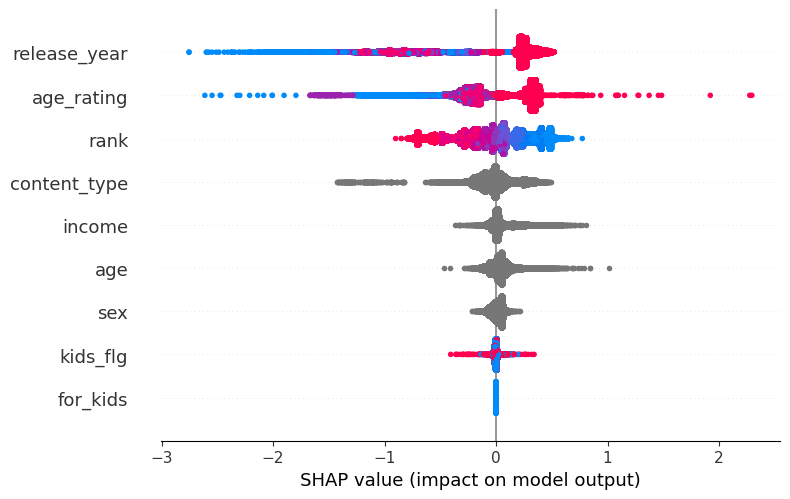

In [66]:
shap.summary_plot(shap_values, X_train, show = False, color_bar = False)

In [67]:
# predictions on test
y_test_pred = cbm_classifier.predict_proba(X_test)

In [68]:
from sklearn.metrics import roc_auc_score

print(f"ROC AUC score = {roc_auc_score(y_test, y_test_pred[:, 1]):.2f}")

ROC AUC score = 0.68


# TODO
- Estimate the performance of the model on the test set using Precision@K, MRR, MAP@K: LightFM seperately, LightFM + Ranker

## LightFM

In [69]:
# your code should be here
def precision_k(y_true: np.array, y_pred: np.array, k: int) -> float:
    """
    y_true: true labels
    y_pred: predicted lables
    k: cutoff length
    """

    # delete condition for positive_results
    if sum(y_true) == 0:
        return -1

    argsort = np.argsort(y_pred)[::-1]
    y_true_sorted = y_true[argsort]
    true_positives = y_true_sorted[:k].sum()

    return true_positives / k

In [70]:
local_train.head(5)

,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,2021-05-11,4250,72.000
1,699317,1659,2021-05-29,8317,100.000
2,864613,7638,2021-07-05,14483,100.000
3,964868,9506,2021-04-30,6725,100.000
4,1032142,6686,2021-05-13,11286,100.000


In [71]:
interactions.head(5)

,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,2021-05-11,4250,72.000
1,699317,1659,2021-05-29,8317,100.000
2,656683,7107,2021-05-09,10,0.000
3,864613,7638,2021-07-05,14483,100.000
4,964868,9506,2021-04-30,6725,100.000


In [72]:
y_pred = test_preds.groupby('user_id')['rank'].apply(lambda x: np.array(x))
y_true = pd.merge(test_preds, interactions, how = 'left', on = ['user_id', 'item_id'])
print(y_true.head(5))
y_true.info()


   user_id item_id  rank           item_name last_watch_dt  total_dur  \
0   646903   10440     1         Хрустальный           NaN        NaN   
1   646903   14741     2  Цвет из иных миров           NaN        NaN   
2   646903   16361     3   Doom: Аннигиляция           NaN        NaN   
3   646903    9728     4   Гнев человеческий           NaN        NaN   
4   646903    9169     5            Взаперти           NaN        NaN   

   watched_pct  
0          NaN  
1          NaN  
2          NaN  
3          NaN  
4          NaN  
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1447390 entries, 0 to 1447389
Data columns (total 7 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   user_id        1447390 non-null  int64  
 1   item_id        1447390 non-null  object 
 2   rank           1447390 non-null  int64  
 3   item_name      1447390 non-null  object 
 4   last_watch_dt  419418 non-null   object 
 5   total_dur      41941

In [73]:
# def filler(data: np.array):
#     result = np.zeros_like(data) 
#     not_missing = ~np.isnan(data) 
#     result[not_missing] = 1 
    # return result


In [74]:
# y_true['last_watch_dt'] = y_true['last_watch_dt'].apply(lambda row: filler(np.array(y_true['last_watch_dt']))[0])

In [75]:
y_true['last_watch_dt'] = y_true['last_watch_dt'].fillna(0)
y_true['y_true'] = y_true['last_watch_dt'].apply(lambda x: 1 if x!=0 else 0)
y_true.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1447390 entries, 0 to 1447389
Data columns (total 7 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   user_id        1447390 non-null  int64  
 1   item_id        1447390 non-null  object 
 2   rank           1447390 non-null  int64  
 3   item_name      1447390 non-null  object 
 4   last_watch_dt  1447390 non-null  int64  
 5   total_dur      419418 non-null   float64
 6   watched_pct    419418 non-null   float64
dtypes: float64(2), int64(3), object(2)
memory usage: 88.3+ MB


In [76]:
y_true = y_true.groupby('user_id')['y_true'].apply(lambda x: np.array(x))

In [77]:
y_true.head(5)

user_id
11    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
21    [0, 1, 1, 1, 0, 1, 0, 0, 1, 0]
30    [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
37    [1, 1, 0, 1, 1, 1, 0, 1, 0, 0]
53    [1, 0, 1, 1, 1, 0, 0, 0, 0, 0]
Name: last_watch_dt, dtype: object

In [78]:
precision_10 = []
for true, pred in zip(y_true, y_pred):
    precision_10.append(precision_k(true, pred, 10))
mean_precision_10 = np.mean(precision_10)
print(f'Mean precision@10: {mean_precision_10}')

Mean precision@10: 0.2211000490538141


In [79]:
def average_precision(y_true: np.array, y_pred: np.array, k: int) -> float:

   
    if sum(y_true) == 0:
        return -1

    if len(y_pred) > k:
        y_pred = y_pred[:k]

    argsort = np.argsort(y_pred)[::-1]
    y_true_sorted = y_true[argsort]

    num_hits = 0
    score = 0

    for i, p in enumerate(y_true_sorted, 1):
        if p == 1:
            num_hits += 1
            score += num_hits / i
    if num_hits == 0:
        output = 0
    
    else:
        output = score / min(len(y_true), k)

    return output

In [80]:
ap_10 = []
for true, pred in zip(y_true, y_pred):
    ap_10.append(average_precision(true, pred, 10))
map_10 = np.mean(ap_10)
print(f'MAP@10: {map_10}')

MAP@10: 0.0602817677182914


In [81]:
def reciprocal_rank(y_true: np.array, y_pred: np.array) -> float:
    
    argsort = np.argsort(y_pred)[::-1]
    y_true_sorted = y_true[argsort]
    for i, val in enumerate(y_true_sorted, 1):     
        if val == 1:
            return 1 / i
    return 0

In [82]:
RR = []
for true, pred in zip(y_true, y_pred):
    RR.append(reciprocal_rank(true, pred))
MRR = np.mean(RR)
print(f'MRR10: {MRR}')

MRR10: 0.35993435967993614


In [83]:
cols = {
    'user_id' : pd.Series(test_preds['user_id'].unique()), 
    'RR' : pd.Series(RR),
    'AP' : pd.Series(ap_10),
    'Precision@10' : pd.Series(precision_10)
}
final_df = pd.DataFrame(cols)
final_df.head(5)


,user_id,RR,AP,Precision@10
0,646903,0.100,0.010,0.100
1,215229,0.500,0.238,0.500
2,81786,0.143,0.014,0.100
3,985101,0.333,0.296,0.600
4,205710,0.167,0.123,0.400


## + Ranker

In [84]:
def precision_k(y_true: np.array, y_pred: np.array, k: int) -> float:
    """
    y_true: true labels
    y_pred: predicted lables
    k: cutoff length
    """

    if sum(y_true) == 0:
        return -1

    argsort = np.argsort(y_pred)[::-1]
    y_true_sorted = y_true[argsort]
    true_positives = y_true_sorted[:k].sum()

    return true_positives / k

In [85]:
y_test_pred = cbm_classifier.predict_proba(X_test)
cbm_test_set['pred'] = y_test_pred[:,1]
cbm_test_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70499 entries, 0 to 70498
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   user_id        70499 non-null  int64         
 1   item_id        70499 non-null  object        
 2   rank           70499 non-null  int64         
 3   item_name      70499 non-null  object        
 4   last_watch_dt  15701 non-null  datetime64[ns]
 5   total_dur      15701 non-null  float64       
 6   watched_pct    15701 non-null  float64       
 7   target         70499 non-null  int64         
 8   age            56653 non-null  object        
 9   income         56693 non-null  object        
 10  sex            56581 non-null  object        
 11  kids_flg       57117 non-null  float64       
 12  content_type   70499 non-null  object        
 13  release_year   70499 non-null  float64       
 14  for_kids       1394 non-null   float64       
 15  age_rating     7049

In [86]:
model_y_pred = cbm_test_set.groupby('user_id')['pred']
model_y_pred = model_y_pred.apply(lambda row: np.array(row))
y_true = cbm_test_set.groupby('user_id')['target']
y_true = y_true.apply(lambda row: np.array(row))

print(model_y_pred.head(5))

print(y_true.head(5))

user_id
166    [0.2617144794197511, 0.08358532234688947, 0.33...
205            [0.2126672888176627, 0.16497528283408586]
240    [0.4037608820130571, 0.34665052785892725, 0.30...
299    [0.41395212586690766, 0.19790614855039235, 0.1...
304    [0.27370189738223427, 0.07821073360342794, 0.3...
Name: pred, dtype: object
user_id
166    [1, 1, 1, 1, 0]
205             [0, 0]
240          [0, 0, 1]
299       [1, 0, 0, 0]
304          [0, 0, 1]
Name: target, dtype: object


In [87]:
r_precision_10 = []
for true, pred in zip(y_true, model_y_pred):
    r_precision_10.append(precision_k(true, pred, 10))
mean_r_precision_10 = np.mean(r_precision_10)
mean_r_precision_10

-0.5077362523956952

In [88]:
def average_precision(y_true: np.array, y_pred: np.array, k: int) -> float:

    if sum(y_true) == 0:
        return -1

    if len(y_pred) > k:
        y_pred = y_pred[:k]

    argsort = np.argsort(y_pred)[::-1]
    y_true_sorted = y_true[argsort]

    num_hits = 0
    score = 0

    for i, p in enumerate(y_true_sorted, 1):
        if p == 1:
            num_hits += 1
            score += num_hits / i
    if num_hits == 0:
        output = 0
    
    else:
        output = score / min(len(y_true), k)

    return output


In [89]:
r_ap_10 = []
for true, pred in zip(y_true, model_y_pred):
    r_ap_10.append(average_precision(true, pred, 10))
r_map_10 = np.mean(r_ap_10)
print(f'MAP@10: {r_map_10}')

MAP@10: -0.381317528670709


In [90]:
def reciprocal_rank(y_true: np.array, y_pred: np.array) -> float:
    
    argsort = np.argsort(y_pred)[::-1]
    y_true_sorted = y_true[argsort]
    for i, val in enumerate(y_true_sorted, 1):     
        if val == 1:
            return 1 / i
    return 0

In [91]:
r_RR = []
for true, pred in zip(y_true, model_y_pred):
    r_RR.append(reciprocal_rank(true, pred))
r_MRR = np.mean(r_RR)
print(f'MRR: {r_MRR}')

MRR: 0.35169975885090876


In [92]:
cols = {
    'user_id' : pd.Series(cbm_test_set['user_id'].unique()), 
    'RR' : pd.Series(r_RR),
    'AP' : pd.Series(r_ap_10),
    'Precision@10' : pd.Series(r_precision_10)
}
final_df = pd.DataFrame(cols)
final_df.head(5)


,user_id,RR,AP,Precision@10
0,1094371,1.000,0.760,0.400
1,849539,0.000,-1.000,-1.000
2,812798,0.333,0.111,0.100
3,666848,1.000,0.250,0.100
4,59464,1.000,0.333,0.100
